<a href="https://colab.research.google.com/github/DanielKorenDataScience/ClassificationProject/blob/main/Classification_Project_Shufersal_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classification Project

for Shufersal on-line orders, for replacing of missing products, will predict the replacement success!

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display
p = print
d = display

# Get Data

## Raw Data

To run the raw section, one must load Sweets_ver2.csv to local google drive and change the next line to True

In [2]:
RAW = False

In [3]:
def get_raw(fname):
  data_url = 'https://github.com/DanielKorenDataScience/ClassificationProject/blob/main/' + fname + '.csv?raw=true'
  resp = requests.get(data_url)
  text = resp.text
  
  with open(fname + '.csv', 'w') as fh:
    fh.write(text)

In [4]:
def diff_list(li1, li2):
  return [i for i in li1 + li2 if i not in li1 or i not in li2]

In [5]:
if RAW:    
  df1 = pd.read_csv('/content/drive/MyDrive/Sweets_ver2.csv', encoding='ISO-8859-8', nrows=1)
  df2 = pd.read_csv('/content/drive/MyDrive/Sweets_ver2.csv', encoding='ISO-8859-8', usecols=[i for i in range(82) if not i in[0,8,10,12,14,16,18,20,24,26,27,48,50,52,54,56,58,62,64,65]])

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
if RAW:
  df1.info()

Eliminating unwanted columns - mostly descriptive columns

In [8]:
if RAW:
  d(diff_list(list(df1.columns), list(df2.columns)))

In [9]:
if RAW:
  d(df2.info())

In [10]:
# Fix Typo mistake
if RAW: 
  df2.rename(columns={'OrderNumbert': 'OrderNumber','BrandIndDescSuss': 'BrandIndDescSubs', 'ProductNumberSubs': 'ParentProductNumberSubs', 
                    'NetSaleNoVatPrdSubs': 'NetSaleNoVatPrdLast3MonthsSubs', 'CafiotSucarSusb': 'CafiotSucarSubs'}, inplace=True)

Eliminating nulls

In [11]:
# Fill na
if RAW:
  df2.fillna({'QuantSale': 1, 'QuantSaleSubs': 1}, inplace=True)
  df2.fillna(0, inplace=True)
  d(df2.info())

In [12]:
if RAW:
  df2.to_csv("Shufersal.csv", index = False)
  p(df2.shape)

In [13]:
if RAW:
  df = pd.read_csv('Shufersal.csv', index_col=False)
  p(df.shape)

## Encoding categories

In [14]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

if RAW:
  enc.fit(['noPromo', 'PromoSusbSamePromo', 'PromoSusbDiffPromo'])
  p(df.isPromo.value_counts())
  p()
  df.isPromo = enc.transform(df.isPromo)
  p(df.isPromo.value_counts())

In [15]:
if RAW:
  for col in ['LocationCityName', 'PeriodHoliday', 'BrandIndDesc', 'BrandName', 'BrandIndDescSubs', 'BrandNameSubs']:
    p(col)
    p(pd.DataFrame(df[col].value_counts()).index)
    df[col] = enc.fit_transform(df[col])
    p(pd.DataFrame(df[col].value_counts()).index)

## Calc diff vector

In [16]:
if RAW:
  df.columns

In [17]:
if RAW:
  for col in ['DepartmentCode', 'CategoryCode', 'GroupCode', 'SubGroupCode',
       'CompoundID', 'ParentProductNumber', 'BrandIndDesc',
       'VendorNumber', 'UnitOfMeasure', 'Price', 'NetSaleNoVatPrdLast3Months', 'Energy', 'Pachmema',
       'Natran', 'Helbon', 'Shuman', 'ShumanRavuy', 'ShumanTrans', 'Colastrol',
       'SivimTzunatim', 'CafiotSucar', 'QuantSale', 'cntMonths', 'DiscountPerUnit']:
    df[col + 'Diff'] = df[col] - df[col + 'Subs']

In [18]:
if RAW:
  for col in ['DepartmentCode', 'CategoryCode', 'GroupCode', 'SubGroupCode',
       'CompoundID', 'ParentProductNumber', 'VendorNumber', 'BrandIndDesc']:
    df[col + 'Diff'] = (df[col + 'Diff'] != 0)
    df[col + 'Diff'] = enc.fit_transform(df[col + 'Diff'])

## Use Dummies

Minimal improvement - FalseNegative (0,0) improved from 1338 to 1328

In [19]:
## Converting the categories column (isPromo) to dummies column 
if RAW:
  p(df.shape)
  df = pd.get_dummies(df, columns=['isPromo', 'PeriodHoliday'])
  p(df.shape)

In [20]:
if RAW:
  df.to_csv("Shufersal_with_diff.csv", index = False)

In [21]:
if RAW:
  df = pd.read_csv('Shufersal_with_diff.csv', index_col=False)
  p(df.shape)

In [22]:
if RAW:
  d(df.head())

# Get ready Data

In [23]:
if not RAW:
  get_raw('Shufersal_with_diff')

In [24]:
if not RAW:
  df = pd.read_csv('Shufersal_with_diff.csv', encoding='ISO-8859-8')
  p(df.shape)
  df.head()

(54460, 89)


# Models

In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

X = df.drop('CorrelateItemStatusCode', axis=1)
y = df.CorrelateItemStatusCode.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

In [26]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import math

pd.set_option("precision", 2)
df_result = pd.DataFrame()

In [27]:
def report_old(clf, X, y, data_type='Test'):
  p()
  p(type(clf).__name__ + ': ' + data_type)
  p('_____________________________________________________')
  acc = accuracy_score(y_true=y, y_pred=clf.predict(X))
  cm = pd.DataFrame(confusion_matrix(y_true=y, y_pred=clf.predict(X)),
                    index=clf.classes_,
                    columns=clf.classes_)
  d(cm)
  rep = classification_report(y_true=y, y_pred=clf.predict(X), zero_division=1, output_dict=True)
  rep =  pd.DataFrame(rep)
  rep.drop(['accuracy', 'macro avg', 'weighted avg'], axis=1, inplace=True)
  rep = rep.T
  rep['accuracy'] = acc
  rep.support = rep.support.astype(int)
  cols = list(rep.columns[:3]) + ['accuracy', 'support']
  rep = rep[cols]
  d(rep)
  return

In [28]:
def report(clf, X, y, data_type='Test'):
  global df_result
  name = type(clf).__name__ + ': ' + data_type
  acc = accuracy_score(y_true=y, y_pred=clf.predict(X))
  index = [(name, clf.classes_[0]), (name, clf.classes_[1])]
  cm = pd.DataFrame(confusion_matrix(y_true=y, y_pred=clf.predict(X)),
                    index=clf.classes_,
                    columns=clf.classes_)
  cm.reset_index(drop=True, inplace=True)
  rep = classification_report(y_true=y, y_pred=clf.predict(X), zero_division=1, output_dict=True)
  rep =  pd.DataFrame(rep)
  rep.drop(['accuracy', 'macro avg', 'weighted avg'], axis=1, inplace=True)
  rep = rep.T
  rep['accuracy'] = acc
  rep.support = rep.support.astype(int)
  cols = list(rep.columns[:3]) + ['accuracy', 'support']
  rep = rep[cols]
  rep['precision_avg'] = rep.precision.mean()
  rep['recall_avg'] = rep.recall.mean()
  rep['f1-score_avg'] = rep['f1-score'].mean()
  rep.reset_index(drop=True, inplace=True)
  df = cm.join(rep)
  df['name'] = name
  df.reset_index(inplace=True)
  #df.set_index(['name', 'index'], inplace=True)
  df_result.reset_index(inplace=True)
  df_result = df_result.append(df, ignore_index=True)
  df_result.set_index(['name', 'index'], inplace=True)
  #d(df_result)
  return

In [29]:
def showFeatureImportance(model, X_train=X_train, threshold=0):
  if type(model).__name__ == 'LogisticRegression':  # no features importance data
    w0 = model.intercept_[0]
    w = model.coef_[0]
    fx_imp = pd.Series(w, index=X_train.columns)
  else:
    fx_imp = pd.Series(model.feature_importances_, index=X_train.columns)
  fx_imp /= fx_imp.sum()
  fx_imp = fx_imp.sort_values()
  fx_imp = fx_imp[fx_imp > threshold]
  fig = plt.figure(figsize=(5,5))
  plt.xlim(0, 1)
  fx_imp.plot(kind='barh', title=type(model).__name__ )

In [30]:
def process_model(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, plot=False, threshold=0):
  p('running: ', type(model).__name__)
  model.fit(X_train, y_train)
  report(model, X_train, y_train, 'Train')
  report(model, X_test, y_test)
  if plot:
    showFeatureImportance(model, X_train, threshold) 

In [31]:
from sklearn.linear_model import LogisticRegression, BayesianRidge, Lasso, Ridge
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingRegressor, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

#Baseline Model

In [33]:
def returnPrec(model,products):
            productCols=['ParentProductNumber','ParentProductNumberSubs']
            val=model[(model[productCols[0]]==products[0]) & (model[productCols[1]]==products[1])]['avgApproval']
            if val.empty ==False:
                #display(val)
                return val.iloc[0]
            #print(val)
            return -1

In [34]:
class BaselineModel:
    def __init__(self, classes_):
        self.classes_ = classes_
    def fit(self,X_, y_):
        #catalogCols=['ParentProductNumber','CompoundID','SubGroupCodeNew','GroupCode']
        cols=['ParentProductNumber','ParentProductNumberSubs']
        group=pd.concat([X_[cols],y_],axis=1).apply(lambda x:x.astype(np.int64))\
            .groupby(cols)\
            .agg({'CorrelateItemStatusCode':[('avgApproval','mean'),('countRows','count')]}).reset_index()
        group.columns=group.columns.droplevel(0)
        group.columns.values[0]=cols[0]
        group.columns.values[1]=cols[1]
        group=group[group['countRows']>=5]
        display(group.head())
        display(len(group))
        self.model=group 
        return self
    
    def predict(self,X_): 
        #print(type(X_))
        y_predPrec = X_.apply(lambda x: returnPrec( model=self.model,products=[x['ParentProductNumber'],
                                                                                 x['ParentProductNumberSubs']]),axis=1)
        #display(y_predPrec)
        y_pred=np.where(y_predPrec>0.5,1,0)
        return y_pred
    def predict_proba(self,X_):
        y_predPrec = X_.apply(lambda x: returnPrec(model=self.model, products=[x['ParentProductNumber'],
                                                                                 x['ParentProductNumberSubs']]),axis=1)
        return y_predPrec

In [35]:
baseline=BaselineModel(df.CorrelateItemStatusCode.unique())

In [36]:
baseline.fit(X_train,y_train)

,ParentProductNumber,ParentProductNumberSubs,avgApproval,countRows
0,161631,161648,0.88,34
1,161631,72909799,0.92,64
8,161631,7290112497918,0.93,14
9,161648,161631,0.92,53
10,161648,72909799,0.96,48


1289

In [37]:
y_pred=baseline.predict(X_test)

##Example baseline model

In [40]:
y_train[(X_train['ParentProductNumber']==161631) & (X_train['ParentProductNumberSubs']==72909799)].sum()\
/len(y_train[(X_train['ParentProductNumber']==161631) & (X_train['ParentProductNumberSubs']==72909799)])

0.921875

In [41]:
baseline.predict_proba(X_test[(X_test['ParentProductNumber']==161631) & (X_test['ParentProductNumberSubs']==72909799)])

345      0.92
4927     0.92
16358    0.92
41198    0.92
25464    0.92
52381    0.92
12346    0.92
34919    0.92
4408     0.92
46446    0.92
7792     0.92
6269     0.92
30101    0.92
3085     0.92
21205    0.92
20330    0.92
16116    0.92
16446    0.92
26106    0.92
42864    0.92
18457    0.92
47503    0.92
dtype: float64

In [42]:
print(len(y_pred[y_pred==0]))
print(len(y_pred[y_pred==1]))
print(len(y_pred[y_pred==-1]))

4908
11430
0


In [43]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.52      0.47      0.50      5419
           1       0.75      0.79      0.77     10919

    accuracy                           0.68     16338
   macro avg       0.64      0.63      0.63     16338
weighted avg       0.68      0.68      0.68     16338



In [ ]:
process_model(BaselineModel(df.CorrelateItemStatusCode.unique()))

# SKLearn models

running:  LogisticRegression
running:  LogisticRegression
running:  GradientBoostingClassifier


KeyboardInterrupt: ignored

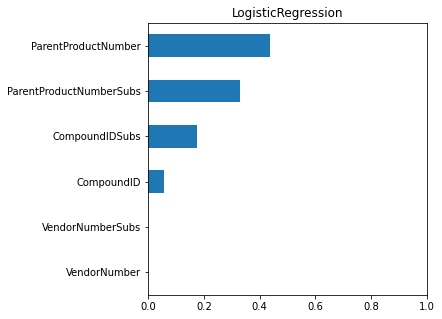

In [32]:
df_result = pd.DataFrame()

process_model(LogisticRegression(max_iter=1000), threshold=0.0000005)  # did not fit, return accuracy=0, so we increased max_iter from default 100
process_model(LogisticRegression(C=100, max_iter=1000, fit_intercept=False, warm_start=True), threshold=0.0000005, plot=True)
process_model(GradientBoostingClassifier(n_estimators=100), plot=True, threshold=0.015)
process_model(AdaBoostClassifier(n_estimators=100))  # base estimator is DecisionTreeClassifier initialized with max_depth=1
process_model(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=100, learning_rate=0.01))
process_model(RandomForestClassifier(n_estimators=64), plot=True, threshold=0.015)
clf_RF = RandomForestClassifier(n_estimators=500, min_samples_split=6, criterion='entropy')
process_model(clf_RF, plot=True, threshold=0.015)
process_model(KNeighborsClassifier(n_neighbors=39))

if False: # ERROR: Classification metrics can't handle a mix of binary and continuous targets
  process_model(GradientBoostingRegressor(n_estimators=100, max_depth=5))
  process_model(BayesianRidge())
  process_model(Lasso())
  process_model(Ridge(alpha = 0.5))
if False: ## too long > 4 minutes
  process_model(LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=0.1, max_iter=20000)) # max_iter increaed from default 1000 to 3000, 6000, 20000 because did not coverged warning
  from sklearn import svm
  process_model(svm.SVC())
  process_model(svm.SVR())

d(df_result)

## Grid Search for hyperparameters - on best model RandonForest

It run for few hours and then colab disconnected - it was to preform 5880 checks. From the partial results (because Verbose=4) I saw that n_estimators=500, min_samples_split=6, criterion='entropy' gives better results so we implemented them and we can see that indeed precision was improved from 84% to 85% 

In [ ]:
GS = False
if GS:
  clf_RF = RandomForestClassifier(n_estimators=64)
  clf_RF.fit(X_train, y_train)
  p(clf_RF.score(X_train, y_train))
  p(clf_RF.score(X_test, y_test))

In [ ]:
if GS:
  param_grid = { 
  #    'max_depth' : [None, 4,5,6,7,8],
      'n_estimators': [64, 200, 500],
      'max_features': ['auto', 'sqrt', 'log2', 1.0, 0.75, 0.5, 0.25],
      'criterion' :['gini', 'entropy'], 
      'max_leaf_nodes': [None, 4, 10, 20],
      'min_samples_split': [2, 4, 6, 8, 10, 12, 14]
  }
  param_grid0 = { 
    'max_depth' : [None, 4,5,6,7,8],   # done seperately - result is None
  }

  clf_RF = RandomForestClassifier()
  clf_gs = GridSearchCV(clf_RF, param_grid, cv=5, verbose=4)
  clf_gs.fit(X_train, y_train)

  p('Results')
  clf_gs.estimator
  p(clf_gs.best_params_)
  p(clf_gs.best_estimator_)

In [ ]:
if GS:
  p(clf_gs.score(X_train, y_train))
  p(clf_gs.score(X_test, y_test))

## cross validation

In [ ]:
k = 7
scores = cross_val_score(clf_RF, X_train, y_train, cv=k)
p("\nscores : " + (k * "{:.3f} ").format(*scores))


scores : 0.844 0.856 0.856 0.854 0.850 0.851 0.853 


# TODO:

In [ ]:
if False:
  
  from sklearn.ensemble import VotingClassifier

  process_model(VotingClassifier(estimators=[('GBR', model1), ('BR', model2), ('KNN', model3)], voting='soft'))

## run a model with the important feature alone to show is it a must or just necessary (if the drop in precision is large it is not a must)?

## Bagging (Bootstrap Aggregation)

> One classifier ("base model") and try to fit many different subsamples of the data

> The hyper-parameters "max_samples" and "max_features" control the size of the subsets

> The hyper-parameters "bootstrap" and "bootstrap_features" control wether the samples and the features are drawn with (or without) replacement

In [ ]:
clf_base = DecisionTreeClassifier(max_depth=5)

In [ ]:
clf_bagging = BaggingClassifier(base_estimator=clf_base, n_estimators=50)
clf_bagging.fit(X_train, y_train)

clf_bagging.score(X_train, y_train)
clf_bagging.score(X_test, y_test)

## Correlation